In [592]:
import os
import glob
import random
import json

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from progressbar import ProgressBar

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.optim as optim
from torchvision import models, transforms
import torchvision.transforms as transforms

# seqmod package imports
from src.utils import set_seed, add_metric_plot
from src.data_source import get_subfolder_names_from_root
from src.dataset import StormWindSpeedSequencedDataset

In [3]:
SEED = 42
set_seed(42)

print(f"SEED = {SEED}")

SEED = 42


In [4]:
DEVICE = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    DEVICE = 'cuda'
else:
    print("No GPU available!")

DEVICE

No GPU available!


'cpu'

In [6]:
from torch.utils.data import Dataset
from torchvision import transforms, io
import os
import glob
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from src.data_source import get_subfolder_names_from_root


class StormImageSequencedDataset(Dataset):
    def __init__(
        self,
        image_root_dir: str,
        image_file_type: str = "jpg",
        storm_name: str | None = None,
        input_sequence_length: int = 10,
        target_sequence_length: int = 1,
        data_split: str = "train",
        split_pct: tuple[float, float] = (0.8, 0.2),  # train, val
        transform: transforms.Compose | None = None,
        random_seed: int = 42,
    ):
        """Initialisation."""

        # images info
        self.image_root_dir = image_root_dir
        self.image_file_type = image_file_type
        self.storm_name = storm_name
        # sequence info
        self.input_sequence_length = input_sequence_length
        self.target_sequence_length = target_sequence_length
        # data info
        self.data_split = data_split
        self.split_pct = split_pct
        self.random_seed = random_seed
        self.transform = transform

        # get desired storms
        self.storm_names = self.get_storm_names()

        # collate all storm images by storm
        self.df_storm_images = self.get_storm_image_data(img_file_type="jpg")

        # create sequenced data of all storms (no cross-overs)
        self.df_sequence = self.create_storm_sequence_data()

        # get data for chosen split
        self.data = self.split_data()


    def get_storm_names(self):
        """"""
        if self.storm_name is not None:
            storm_names = [self.storm_name]
        else:
            storm_names = get_subfolder_names_from_root(root_dir=self.data_root_dir)
            if self.storms_to_exclude is not None:
                storm_names = [s for s in storm_names if s not in self.storms_to_exclude]
            
        return storm_names    

    def split_data(self):
        """"""
        df_train, df_val = train_test_split(
            self.df_sequence,
            train_size=self.split_pct[0],
            random_state=self.random_seed,
            shuffle=True,
        )
        if self.data_split == "train":
            return df_train
        elif self.data_split == "val":
            return df_val
        elif self.data_split is None:
            # ability to return all of the data if needed i.e inference.
            return self.df_sequence
        else:
            raise ValueError("Need to input either 'train', 'val' or None.")

    def get_storm_image_data(self, img_file_type: str = "jpg"):
        """"""
        storm_images_dict = (
            {}
        )  # store storm images (values) under each storm name (key)
        for storm in self.storm_names:
            images = []
            storm_img_path = os.path.join(
                self.image_root_dir, storm, f"*.{img_file_type}"
            )
            for img in sorted(glob.glob(storm_img_path)):
                # store each image for storm to add to dict
                images.append(img)

            storm_images_dict[storm] = images

        # unpack the storm image dictionary
        df_imgs = []
        for k, v in storm_images_dict.items():
            df_imgs.append(pd.DataFrame(data=v, columns=[k]))

        df_storm_images = pd.concat(objs=[df for df in df_imgs], axis=1)

        return df_storm_images

    def create_storm_sequence_data(self):
        """"""
        # create the sequence df
        storm_seq = []
        for _storm_name in self.df_storm_images.columns:
            # subset to only storm and make an array of the image file paths
            df_img_paths = self.df_storm_images[_storm_name]
            storm_img_arr = np.array(df_img_paths.dropna().values)
            for i in range(0, len(storm_img_arr) - self.input_sequence_length):
                # sliding window of size = input_sequence length+1
                # window contains [input sequence (in order), target sequence]
                storm_seq.append(
                    storm_img_arr[
                        i: i
                        + (self.input_sequence_length + self.target_sequence_length)
                    ]
                )

        # create sliding window labels for the columns
        columns = [
            f"t{i}"
            for i in range(
                -1 * (self.input_sequence_length - 1), 1 + self.target_sequence_length
            )
        ]

        df_sequence = pd.DataFrame(data=storm_seq, columns=columns)

        return df_sequence

    def __len__(self):
        """"""
        return len(self.data)

    def __getitem__(self, idx):
        """"""
        img_tensors = [
            io.read_image(img_path) for img_path in self.data.iloc[idx].copy()
        ]

        # normalise the pixels (/max(pixel))
        img_tensors = torch.stack(img_tensors) / 255

        if self.transform:
            img_tensors = self.transform(img_tensors)

        # make sure pixels are in [0, 1]
        assert (img_tensors.max() <= 1) & (img_tensors.min() >= 0)

        image_seq, target_seq = (
            img_tensors[: self.input_sequence_length],
            img_tensors[self.input_sequence_length:],
        )

        return image_seq, target_seq

In [615]:
##### DATASET INPUTS #####
IMAGE_ROOT_DIR = '../data/'
STORM_NAME = 'eoi'
INPUT_SEQUENCE_LENGTH = 3
TARGET_SEQUENCE_LENGTH = 1
DATA_SPLIT = (0.8, 0.2)

# debug info
print("\t\t#### DATASET INFO ####\n")
print(f"\t--> IMAGE ROOT DIR = {IMAGE_ROOT_DIR}")
print(f"\t--> STORM NAME = {STORM_NAME}")
print(f"\t--> INPUT SEQUENCE LENGTH = {INPUT_SEQUENCE_LENGTH}")
print(f"\t--> TARGET SEQUENCE LENGTH = {TARGET_SEQUENCE_LENGTH}")
print(f"\t--> DATA SPLIT = {DATA_SPLIT}")


##### DATALOADER INPUTS #####
BATCH_SIZE = 4
NUM_WORKERS = 0

print("\n\n\t\t#### DATALOADER INFO ####\n")
print(f"\t--> BATCH SIZE = {BATCH_SIZE}")
print(f"\t--> NUM WORKERS {NUM_WORKERS}")

		#### DATASET INFO ####

	--> IMAGE ROOT DIR = ../data/
	--> STORM NAME = eoi
	--> INPUT SEQUENCE LENGTH = 3
	--> TARGET SEQUENCE LENGTH = 1
	--> DATA SPLIT = (0.8, 0.2)


		#### DATALOADER INFO ####

	--> BATCH SIZE = 4
	--> NUM WORKERS 0


In [616]:
# transforms applied
DESIRED_IMAGE_DIMS = (366, 366)
print(f"DESIRED DIMS (Resizing) = {DESIRED_IMAGE_DIMS}\n")

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(DESIRED_IMAGE_DIMS, antialias=True),
])

transform

DESIRED DIMS (Resizing) = (366, 366)



Compose(
    Grayscale(num_output_channels=1)
    Resize(size=(366, 366), interpolation=bilinear, max_size=None, antialias=True)
)

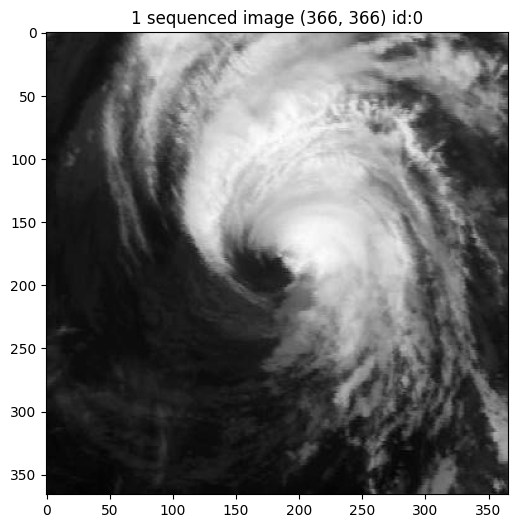

In [617]:
dummy = StormImageSequencedDataset(
    image_root_dir=IMAGE_ROOT_DIR,
    image_file_type='jpg',
    storm_name=STORM_NAME,
    input_sequence_length=INPUT_SEQUENCE_LENGTH,
    target_sequence_length=TARGET_SEQUENCE_LENGTH,
    data_split='train',
    split_pct=DATA_SPLIT,  # (train, val)
    transform=transform
    )


# run a pass through the dataset and plot a storm.
idx, img_sequence_num = 0, 0
img_sequence, target = dummy.__getitem__(idx)

# plot storm
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(img_sequence[0, 0, :, :], cmap='gray')
ax.set_title(f"{img_sequence_num+1} sequenced image {DESIRED_IMAGE_DIMS} id:{idx}", fontsize=12)

# ensure that the dataset doesnt contain test storm
assert len([i for i in dummy.storm_names if i == 'ztb']) == 0

In [618]:
### Create datasets
train_dataset = StormImageSequencedDataset(
    image_root_dir=IMAGE_ROOT_DIR,
    image_file_type='jpg',
    input_sequence_length=INPUT_SEQUENCE_LENGTH,
    target_sequence_length=TARGET_SEQUENCE_LENGTH,
    storm_name=STORM_NAME,
    data_split='train',
    split_pct=DATA_SPLIT,  # (train, val)
    transform=transform
    )

val_dataset = StormImageSequencedDataset(
    image_root_dir=IMAGE_ROOT_DIR,
    image_file_type='jpg',
    input_sequence_length=INPUT_SEQUENCE_LENGTH,
    target_sequence_length=TARGET_SEQUENCE_LENGTH,
    storm_name=STORM_NAME,
    data_split='val',
    split_pct=DATA_SPLIT, # (train, val)
    transform=transform
    )

print("\n\n\t\t#### TENSOR INFO ####\n")
print(f"\t --> Train Dataset: {train_dataset.__len__()} | dims: {train_dataset.data.shape}")
print(f"\t --> Validation Dataset: {val_dataset.__len__()} | dims: {val_dataset.data.shape} ")



		#### TENSOR INFO ####

	 --> Train Dataset: 388 | dims: (388, 4)
	 --> Validation Dataset: 97 | dims: (97, 4) 


In [619]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS,
                                         shuffle=False)

train_loader.dataset.__len__(), val_loader.dataset.__len__()

(388, 97)

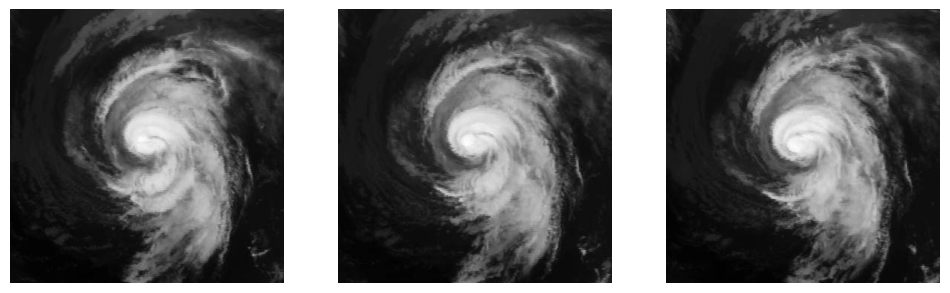

In [622]:
# plot a batch
train_batch = next(iter(train_loader))
img_seq, target_seq = train_batch
_batch_num = 1

# plot input sequence
_, axs = plt.subplots(nrows=1, ncols=INPUT_SEQUENCE_LENGTH, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(img_seq[_batch_num, :, 0, :, :], axs):
    ax.imshow(img.squeeze(0), cmap='gray')
    ax.axis('off')

plt.show()

In [644]:
from collections import OrderedDict
from typing import List, Tuple


class ConvLSTMCell(nn.Module):
    """ConvLSTMCell module.

    Parameters
    ----------
    input_channels : Tuple[int, int, int]
        The number of channels (C, _, _) of each image in the input image sequence.
    input_height : Tuple[int, int, int]
        The height (_, H, _) of each image in the input image sequence.
    input_width : Tuple[int, int, int]
        The width (_, _, W) of each image in the input image sequence. 
    hidden_channels:  int
        The number of hidden channels. This is the number of output channels in the convolution(i, h).
    kernel_size: Tuple[int]
        The size of the kernel to perform the convolutional operations.
    apply_batchnorm : bool, optional
        If `True`, a batchnorm will be applied after each convolution(i, h) in each ConvLSTM cell. Default is `True`.
    bias : bool, optional
        If `True`, the LSTM layers will use bias weights. Default is `True`.
    device : str
        The device (CPU or GPU) on which the model will be run. Should be specified as a string ('cpu' or 'cuda'). Default is 'cpu'.
    _print : bool, optional
        If `True`, enables printing of model-related information for debugging or logging. Default is `False`.
    """
    def __init__(self, 
                 input_channels: int,
                 input_height: int,
                 input_width: int,
                 hidden_channels: int,
                 kernel_size: int,
                 apply_batchnorm:bool=True,
                 bias:bool=True,
                 device:str='cpu',
                 _print:bool=False):
        """Initialisation."""
        super(ConvLSTMCell, self).__init__()

        # seeded for reproducibility.
        set_seed(SEED)

        # inputs.
        self.input_channels = input_channels  # input_channels is equivalent to self.input_size in LSTM (how many features ~ how many channels...)
        self.input_height = input_height
        self.input_width = input_width
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.bias = bias
        self.apply_batchnorm = apply_batchnorm
        self.device = device
        self.print = _print

        # debug info
        if self.print:
            print("\n------ CONVOLUTION DIMS -------")
            print(f"Conv input: {(self.input_channels + self.hidden_channels)} [i: {self.input_channels}, h: {self.hidden_channels}]")
            print(f"Conv output: {4 * self.hidden_channels}")

        if self.apply_batchnorm:
            self.conv_input_and_hidden = nn.Sequential(OrderedDict([
                ('conv_layer', nn.Conv2d(in_channels=(self.input_channels + self.hidden_channels),
                                         out_channels=(4 * self.hidden_channels),
                                         kernel_size=self.kernel_size,
                                         padding=(1, 1),
                                         bias=self.bias)
                ),
                ('batchnorm', nn.BatchNorm2d(num_features=(4 * self.hidden_channels)))
                ]))
        else:
            # no batch normalisation applied after convolution.
            self.conv_input_and_hidden = nn.Conv2d(in_channels=(self.input_channels + self.hidden_channels),
                                                   out_channels=(4 * self.hidden_channels),
                                                   kernel_size=self.kernel_size,
                                                   padding=(1, 1),
                                                   bias=self.bias)

        # initialise the weights (and biases) of the self.conv_input_and_hidden convolution layer.
        self._initialise_parameters(layer=self.conv_input_and_hidden)
        
        # initialise the weights for Hadamard Products
        self.Wci, self.Wcf, self.Wco = self._init_hadamard_products_weights()

    def _initialise_parameters(self, layer):
        """Initialise the layer weights and biases with a unform dist [-std, std], where std = sqrt(1/hidden_channels). 
        For the convolutional layer: number of weights = (out_channels, in_channels, *(kernel_size)), number of biases = (out_channels).
        
        Parameters
        ----------
        layer : torch.nn.Module
            The layer whose parameters are to be initialized. This should be a layer from a PyTorch model,
            such as a convolutional layer, that has weights and biases as its parameters.
        """
        std = (1 / np.sqrt(self.hidden_channels))
        for _, _param in enumerate(layer.parameters()):
            _param.data.uniform_(-std, std)

    def _init_hadamard_products_weights(self):
        """Initialise the weights used in the Hadamard Product details in - https://arxiv.org/abs/1506.04214.
        
        These are initialised w/ dims: (1, hidden_channels, H, W). The weights are initialised so that each cell
        within each layer shares the same Wci, Wcf, and Wco weights but these are distinct from those in other layers.
        There will be only 1 set of trainable Wci, Wcf and Wco per layer. 
        """
        #TODO: do I need this to have dims: (batch_size, , , )
        Wci = torch.zeros(1, self.hidden_channels, self.input_height, self.input_width, requires_grad=True).to(self.device)
        Wcf = torch.zeros(1, self.hidden_channels, self.input_height, self.input_width, requires_grad=True).to(self.device)
        Wco = torch.zeros(1, self.hidden_channels, self.input_height, self.input_width, requires_grad=True).to(self.device)

        return Wci, Wcf, Wco

    def forward(self, i: torch.Tensor, h: torch.Tensor, c: torch.Tensor):
        """Forward pass through the ConvLSTM Cell.

        Parameters
        ----------
        i : torch.Tensor
            input image into ConvLSTM cell w/ dims: (batch_size, channels, height, width)
        h : torch.Tensor
            input hidden state into ConvLSTM cell w/ dims: (batch_size, channels, height, width)
        c : torch.Tensor
            input cell state into ConvLSTM cell w/ dims: (batch_size, channels, height, width)

        Returns
        -------
        h_t: torch.Tensor
            output hidden state w/ dims: (batch_size, channels, height, width)
        c_t: torch.Tensor
            output cell state w/ dims: (batch_size, channels, height, width)
        """
        if self.print:
            print("\n---------------------- ConvLSTM CELL ----------------------")
            print(f"Conv LSTM Cell Inputs:")
            print(f"\tinput channels = {i.size(1)} || {self.input_channels}")
            print(f"\thidden channels = {h.size(1)} || {self.hidden_channels}")
            print(f"\tcell state channels = {c.size(1)}\n")

        # bottom left of the LSTM cell (diagram). This is performing a convolution on the combined input i(t) with h(t-1)
        gates = self.conv_input_and_hidden(torch.cat([i, h], dim=1))
        
        input_gate, forget_gate, candidate_update, output_gate = gates.chunk(4, dim=1) # separate the output into each of cell gate operations

        # apply the corresponding activations [details in - https://arxiv.org/abs/1506.04214]
        i_t = torch.sigmoid(input_gate + (self.Wci*c))  # it = σ((Wxi * Xt + Whi * Ht−1) + (Wci o Ct−1) + bi)
        f_t = torch.sigmoid(forget_gate + (self.Wcf*c))  # ft = σ((Wxf * Xt + Whf * Ht−1) + (Wcf o Ct−1) + bf)
        cd_t = (c*f_t) + (i_t*torch.tanh(candidate_update))  # Ct = (ft o Ct−1) + (it o tanh((Wxc * Xt + Whc * Ht−1) + bc))
        o_t = torch.sigmoid(output_gate + (self.Wco*c))  # ot = σ((Wxo * Xt + Who * Ht−1) + (Wco o Ct) + bo)

        if self.print:
            print("LSTM Cell Gate Outputs:")
            print(f"\tinput gate = {i_t.size()}")
            print(f"\tforget gate = {f_t.size()}")
            print(f"\tcandidate update = {cd_t.size()}")
            print(f"\toutput update = {o_t.size()}\n")

        # calculate the next cell state
        c_t = (f_t * c) + (i_t * cd_t)

        # calculate the next hidden state
        h_t = o_t * torch.tanh(c_t)

        if self.print:
            print("LSTM Cell Outputs:")
            print(f"\tc_t = {c_t.size()}")
            print(f"\th_t = {h_t.size()}")
            
        return h_t, c_t 

In [645]:
class ConvLSTM(nn.Module):
    """ConvLSTM module.

    Parameters
    ----------
    input_sequence_length : int
        The length of the input image sequence. Determines how many ConvLSTM cells are in each layes - 1 cell per element in sequence.
    input_dims : Tuple[int, int, int]
        The (C, H, W) [number of channels, height, width] of each image in the input image sequence. 
    hidden_channels:  List[int]
        A list of the number of channels for the convolutional output for each layer. There should be a hidden_channel values for each layer.
    output_channels:  int
        The desired number of channels in the convoled hidden outputs from the cells in the last layer.
    num_layers : int
        Number of stacked ConvLSTM layers.Each ConvLSTM layer, m will consist of n ConvLSTMCells where n = input seuqnce length. 
    kernel_size: Tuple[int]
        The size of the kernel to perform the convolutional operations.
    apply_batchnorm : bool, optional
        If `True`, a batchnorm will be applied after each convolution(i, h) in each ConvLSTM cell. Default is `True`.
    bias : bool, optional
        If `True`, the LSTM layers will use bias weights. Default is `True`.
    device : str
        The device (CPU or GPU) on which the model will be run. Should be specified as a string ('cpu' or 'cuda'). Default is 'cpu'.
    _print : bool, optional
        If `False`, enables printing of model-related information for debugging or logging. Default is `False`.
    """
    def __init__(self, 
                 input_sequence_length: int,
                 input_dims: Tuple[int, int, int],
                 hidden_channels: List[int],
                 output_channels: int,
                 num_layers: int,
                 kernel_size: Tuple[int],
                 apply_batchnorm:bool=True,
                 bias:bool=True,
                 device:str='cpu',
                 _print:bool=True):
        """Initialisation."""
        super(ConvLSTM, self).__init__()

        set_seed(SEED)

        self.input_sequence_length = input_sequence_length
        self.input_dims = input_dims
        self.input_channels, self.input_height, self.input_width = input_dims
        self.hidden_channels = hidden_channels
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.bias = bias
        self.apply_batchnorm = apply_batchnorm
        self.device = device
        self.print = _print

        # create a list of lstm cell modules
        self.conv_lstm_cell_list = nn.ModuleList()

        assert len(self.hidden_channels) == self.num_layers

        # create each layer in the network
        for l in range(self.num_layers):
            if self.print:    print(f"Adding ConvLSTM Cell (layer) {l}...")
            _cell = ConvLSTMCell(input_channels=(self.input_channels if l == 0 else self.hidden_channels[l-1]),
                                 input_height=self.input_height,
                                 input_width=self.input_width,
                                 hidden_channels=self.hidden_channels[l],
                                 kernel_size=self.kernel_size,
                                 bias=self.bias,
                                 apply_batchnorm=self.apply_batchnorm,
                                 device=self.device,
                                 _print=self.print,
                             )

            self.conv_lstm_cell_list.append(_cell)

        # create a final convolutional layer from hidden state to network output
        self.conv_hidden_to_output = nn.Conv2d(in_channels=self.hidden_channels[-1], # take the hidden channels from the last layer.
                                               out_channels=self.output_channels,
                                               kernel_size=self.kernel_size,
                                               padding=(1, 1),
                                               bias=self.bias,
                                               )
        
        # initilaise weights of the conv_hidden2output layer
        self._initialise_parameters(layer=self.conv_hidden_to_output)

    def _initialise_parameters(self, layer):
        """Initialise the layer weights and biases with a unform dist [-std, std], where std = sqrt(1/hidden_channels). 
        For the convolutional layer: number of weights = (out_channels, in_channels, *(kernel_size)), number of biases = (out_channels).
        
        Parameters
        ----------
        layer : torch.nn.Module
            The layer whose parameters are to be initialized. This should be a layer from a PyTorch model,
            such as a convolutional layer, that has weights and biases as its parameters.
        """
        std = (1 / np.sqrt(self.hidden_channels[-1]))
        for _, _param in enumerate(layer.parameters()):
            _param.data.uniform_(-std, std)
    
    def _init_hidden_and_cell_states(self, batch_size):
        """Initialise the _hidden_states and _cell_states that will go into the 1st ConvLSTM cells in each layer.
        
        _states are initialised to zero w/ dims: (batch_size, hidden_channels, input_image_height, input_image_width).
        The position of the _state in the list corresponds to the layer.
        """
        hs, cs = [], []
        for _layer in range(self.num_layers):
            if self.print: print(f"Adding h, c states w/ dims: ({(batch_size, self.hidden_channels[_layer], self.input_height, self.input_width)}) @ layer {_layer}.")
            hs.append(torch.zeros(batch_size, self.hidden_channels[_layer], self.input_height, self.input_width, requires_grad=False).to(self.device))
            cs.append(torch.zeros(batch_size, self.hidden_channels[_layer], self.input_height, self.input_width, requires_grad=False).to(self.device))

        return hs, cs
    
    def forward(self, x: torch.Tensor, h0: torch.Tensor, c0: torch.Tensor):
        """Forward pass through the ConvLSTM.

        Parameters:
        ----------
        x : torch.Tensor
            The input image sequence to each cell in the 1st layer w/ dims: (batch_size, sequence_length, num_channels, height, width)
        h0 : torch.Tensor
            The input hidden states (for each layer) w/ dims: (batch_size, sequence_length, num_channels, height, width)
        c0 : torch.Tensor
            The input cell states (for each layer) w/ dims: (batch_size, sequence_length, num_channels, height, width)

        Returns
        -------
        torch.Tensor
            The output of each ConvLSTMCell in the last layer.
        
        Workflow:
        ---------
                                                output1                            output2                                outputN
                                                   ^                                  ^                                      ^
                                                   | (hN,1)                           | (hN,2)                               | (hN,n)
        LayerN:    (hN,0, cn,0)--> [(C(h2,1, hN,0)) ] -> (hn,1, cn,1) [(C(h2,2, hN,1)) ] -> (hn,2, cn,2) ... [(C(h2,n, hN,n)) ]
                                                   ^                                   ^                                      ^
                                                   | (h2,1)                            | (h2,2)                               | (h2,n)
        Layer2:   (h2,0, c2,0)--> [(C(h1,1, h2,0)).. ] -> (h2,1, c2,1) [(C(h1,2, h2,1)).. ] -> (h2,2, c2,2) ... [(C(h1,n, h2,2)).. ]
                                                 ^                                  ^                                     ^
                                                 | (h1,1)                           | (h1,2)                              | (h1,n)
        Layer1: (h1,0, c1,0) --> [(C(i1, h1,0))..  ] -> (h1,1, c1,1) [(C(i1, h1,0)..  ] -> (h1,2, c1,2) ... [C(iN, h1,2)..  ]
                                        ^                                   ^                                     ^
                                        |                                   |                                     |
                                      input1                               input2                               inputN
        """
        _hidden_states = []
        _cell_states = []
        for layer in range(self.num_layers):
            _hidden_states.append(h0[layer])
            _cell_states.append(c0[layer])

        _outputs = []        
        for t in range(x.size(1)): # loop over each element in the input sequence.
            for layer in range(self.num_layers): # loop over each layer in the network.
                if layer == 0:
                    # each cell in the 1st layer takes in the raw element from the input sequence + hidden state and a cell state.
                    hidden_l, cell_l = self.conv_lstm_cell_list[layer](i=x[:, t, :, :, :], h=_hidden_states[layer], c=_cell_states[layer])
                else:
                    # each cell in > 1st layer takes in 2 hidden states as input and hidden and a cell state.
                    hidden_l, cell_l = self.conv_lstm_cell_list[layer](i=_hidden_states[layer-1], h=_hidden_states[layer], c=_cell_states[layer])
                
                # update the hidden and cell states.
                _hidden_states[layer] = hidden_l
                _cell_states[layer] = cell_l

            # the output from each cell in the last layer.
            _outputs.append(hidden_l)

        assert len(_outputs) == self.input_sequence_length

        # apply a convolution from each output in the last layer to the desired number of channels
        output = torch.stack([self.conv_hidden_to_output(_out) for _out in _outputs], dim=1)

        return output

In [646]:
class ConvLSTMModel(nn.Module):
    """Wrapper module for the ConvLSTM.

    Parameters
    ----------
    input_sequence_length : int
        The length of the input image sequence. Determines how many ConvLSTM cells are in each layes - 1 cell per element in sequence.
    output_sequence_length : int
        The desired length of the output image sequence. Return last output_sequence_length number of convolved hidden outputs from the last layer.
    input_dims : Tuple[int, int, int]
        The (C, H, W) [number of channels, height, width] of each image in the input image sequence. 
    hidden_channels:  List[int]
        A list of the number of channels for the convolutional output for each layer. There should be a hidden_channel values for each layer.
    output_channels:  int
        The desired number of channels in the convoled hidden outputs from the cells in the last layer.
    num_layers : int
        Number of stacked ConvLSTM layers.Each ConvLSTM layer, m will consist of n ConvLSTMCells where n = input seuqnce length. 
    kernel_size: Tuple[int]
        The size of the kernel to perform the convolutional operations.
    apply_batchnorm : bool, optional
        If `True`, a batchnorm will be applied after each convolution(i, h) in each ConvLSTM cell. Default is `True`.
    bias : bool, optional
        If `True`, the LSTM layers will use bias weights. Default is `True`.
    device : str
        The device (CPU or GPU) on which the model will be run. Should be specified as a string ('cpu' or 'cuda'). Default is 'cpu'.
    _print : bool, optional
        If `True`, enables printing of model-related information for debugging or logging. Default is `False`.
    """
    def __init__(self, 
                 input_sequence_length: int,
                 output_sequence_length: int,
                 input_dims: Tuple[int, int, int],
                 hidden_channels: List[int],
                 output_channels: int,
                 num_layers: int,
                 kernel_size: Tuple[int],
                 apply_batchnorm:bool=True,
                 bias:bool=True,
                 device:str='cpu',
                 _print:bool=False):
        """Initialisation."""        
        super(ConvLSTMModel, self).__init__()
        
        # seeded for reproducibility.
        set_seed(SEED)

        # inputs.
        self.input_sequence_length = input_sequence_length
        self.output_sequence_length = output_sequence_length
        assert self.output_sequence_length <= self.input_sequence_length

        self.input_dims = input_dims
        self.hidden_channels = hidden_channels
        self.output_channels = output_channels
        self.num_layers = num_layers
        self.kernel_size = kernel_size
        self.apply_batchnorm = apply_batchnorm
        self.bias = bias
        self.device = device
        self.print = _print

        # create the ConvLSTM network.    
        self.convlstm = ConvLSTM(input_sequence_length=self.input_sequence_length,
                                 input_dims=self.input_dims,
                                 hidden_channels=self.hidden_channels,
                                 output_channels=self.output_channels,
                                 kernel_size=self.kernel_size,
                                 num_layers=self.num_layers,
                                 bias=self.bias,
                                 apply_batchnorm=self.apply_batchnorm,
                                 device=self.device,
                                 _print=self.print)

    def forward(self, x: torch.Tensor):
        """Forward pass through the Convolution LSTM Model. 
        
        Parameters:
        ----------
        x : torch.Tensor
            The input image sequence with dims: (batch_size, sequence_length, num_channels, height, width).

        Returns
        -------
        torch.Tensor
            Return the last <self.output_sequence_length> convolved hidden outputs after applying nn.Sigmoid() to make sure pixels are [0,1].

            output w/ dims: (batch_size, output_sequence_length, num_channels, height, width).
        """
        # create the initial h0 and c0 for input into each of the ConvLSTM layers
        h0, c0 = self.convlstm._init_hidden_and_cell_states(batch_size=x.size(0))
        output_sequence = self.convlstm(x=x, h0=h0, c0=c0)

        # take only desired output length and apply nn.Sigmoid
        output = nn.Sigmoid()(output_sequence[:, -self.output_sequence_length:, :, :, :])
        
        return output

In [647]:
KERNEL_SIZE = (3, 3)
INPUT_DIMS = (1, 366, 366)  # C, H, W
HIDDEN_CHANNELS = [16, 16]
OUTPUT_CHANNELS = 1
NUM_LAYERS = 2
OUTPUT_SEQUENCE_LENGTH = 1

StormCLSTM = ConvLSTMModel(input_sequence_length=INPUT_SEQUENCE_LENGTH,
                           output_sequence_length=OUTPUT_SEQUENCE_LENGTH,
                           input_dims=INPUT_DIMS,
                           hidden_channels=HIDDEN_CHANNELS,
                           output_channels=OUTPUT_CHANNELS,
                           num_layers=NUM_LAYERS,
                           kernel_size=KERNEL_SIZE,
                           bias=True,
                           apply_batchnorm=True,
                           device=DEVICE,
                           _print=False
                           )

In [648]:
# run a pass through the untrained network...
_test_output = StormCLSTM(x=img_seq)
_test_output.size()

torch.Size([4, 1, 1, 366, 366])

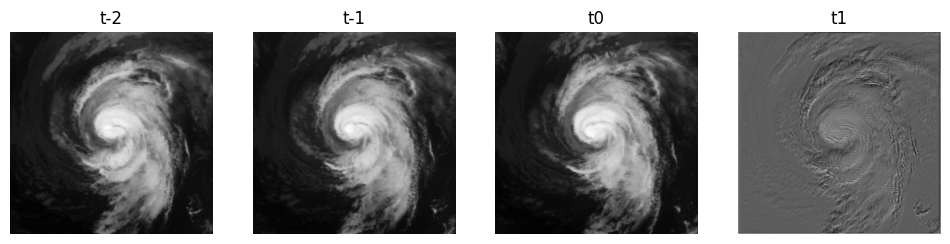

In [649]:
# plot a batch
BATCH_NUM = 1
C = 0  # only 1 channel

fig, axs = plt.subplots(1, INPUT_SEQUENCE_LENGTH+OUTPUT_SEQUENCE_LENGTH, figsize=(12,12))
for _col in range(INPUT_SEQUENCE_LENGTH+OUTPUT_SEQUENCE_LENGTH):
    if _col < INPUT_SEQUENCE_LENGTH:
        axs[_col].imshow(img_seq[BATCH_NUM, _col-INPUT_SEQUENCE_LENGTH, C, :, :], cmap='gray')
        axs[_col].set_title(f"t{_col-(INPUT_SEQUENCE_LENGTH)+1}")
        axs[_col].axis('off')
    else:
        # plotting predicted image
        axs[_col].imshow(_test_output[BATCH_NUM, 0, C, :, :].detach().cpu(), cmap='gray')
        axs[_col].set_title(f"t{_col-(INPUT_SEQUENCE_LENGTH)+1}")
        axs[_col].axis('off')

In [698]:
# lets do some training....

from torch.optim import Adam

KERNEL_SIZE = (3, 3)
INPUT_DIMS = (1, 366, 366)  # C, H, W
HIDDEN_CHANNELS = [8]
OUTPUT_CHANNELS = 1
NUM_LAYERS = 1
OUTPUT_SEQUENCE_LENGTH = 1

model = ConvLSTMModel(input_sequence_length=INPUT_SEQUENCE_LENGTH,
                      output_sequence_length=OUTPUT_SEQUENCE_LENGTH,
                      input_dims=INPUT_DIMS,
                      hidden_channels=HIDDEN_CHANNELS,
                      output_channels=OUTPUT_CHANNELS,
                      num_layers=NUM_LAYERS,
                      kernel_size=KERNEL_SIZE,
                      bias=True,
                      apply_batchnorm=True,
                      device=DEVICE,
                      _print=False
                      )

model = model.to(DEVICE)

optimiser = Adam(model.parameters(), lr=1e-4)

# Binary Cross Entropy, target pixel values either 0 or 1
criterion = nn.BCELoss(reduction='sum')

model

ConvLSTMModel(
  (convlstm): ConvLSTM(
    (conv_lstm_cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv_input_and_hidden): Sequential(
          (conv_layer): Conv2d(9, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (conv_hidden_to_output): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [699]:
EPOCHS = 15

train_losses, val_losses = [], []
for i in range(EPOCHS):
    # training
    model.train()
    train_loss = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        for _, (X, y) in enumerate(tepoch):
            X, y = X.to(DEVICE), y.to(DEVICE)
            output = model(X)
            loss = criterion(output.flatten(), y.flatten())
            loss.backward()
            train_loss += loss.item()
            optimiser.step()
            tepoch.set_postfix(batch_loss=loss.item())
    train_losses.append(train_loss / len(train_loader.dataset))
    
    # validation
    model.eval()
    val_loss = 0
    with tqdm(val_loader, unit="batch") as tepoch:
        for _, (X, y) in enumerate(tepoch):
            X, y = X.to(DEVICE), y.to(DEVICE)
            output = model(X)
            loss = criterion(output.flatten(), y.flatten())
            loss.backward()
            val_loss += loss.item()
        
    val_losses.append(val_loss / len(val_loader.dataset))

 32%|███▏      | 31/97 [00:35<01:23,  1.26s/batch, batch_loss=3.08e+5]

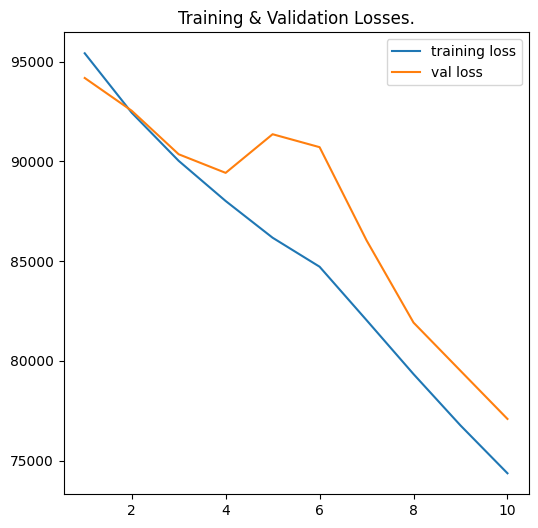

In [ ]:
# plot losses and accuracies
fig, ax = plt.subplots(figsize=(6, 6))

# training
add_metric_plot(axes=ax,
                X=np.arange(1, len(train_losses)+1, 1),
                y=train_losses,
                legend="training loss",
                colour="C0")

# training
add_metric_plot(axes=ax,
                X=np.arange(1, len(val_losses)+1, 1),
                y=val_losses,
                legend="val loss",
                colour="C1")

# plot config
ax.set_title("Training & Validation Losses.", fontsize=12)
ax.legend(loc='best')

In [ ]:
# basic inference
val_batch = next(iter(val_loader))
_img_seq, _target_seq = val_batch
C = 0 # single channel

# generate single next image from a sequence
pred_img = model(_img_seq.to(DEVICE))

fig, axs = plt.subplots(nrows=BATCH_SIZE , ncols=(INPUT_SEQUENCE_LENGTH+1), figsize=(32, 20))
for r in range(axs.shape[0]):
    for c in range(axs.shape[-1]):
        if c <= (INPUT_SEQUENCE_LENGTH-1):
            axs[r, c].imshow(_img_seq[r, c, 0, :, :].detach().cpu(), cmap='gray')
            axs[r, c].set_title(f"Image Sequence Num = {INPUT_SEQUENCE_LENGTH - c}", fontsize=12)
        else:
            axs[r, c].imshow(pred_img[r, -1:, 0, :, :][C].detach().cpu(), cmap='gray')
            axs[r, c].set_title("t+1...", fontsize=16)

        axs[r, c].axis('off')

plt.tight_layout()

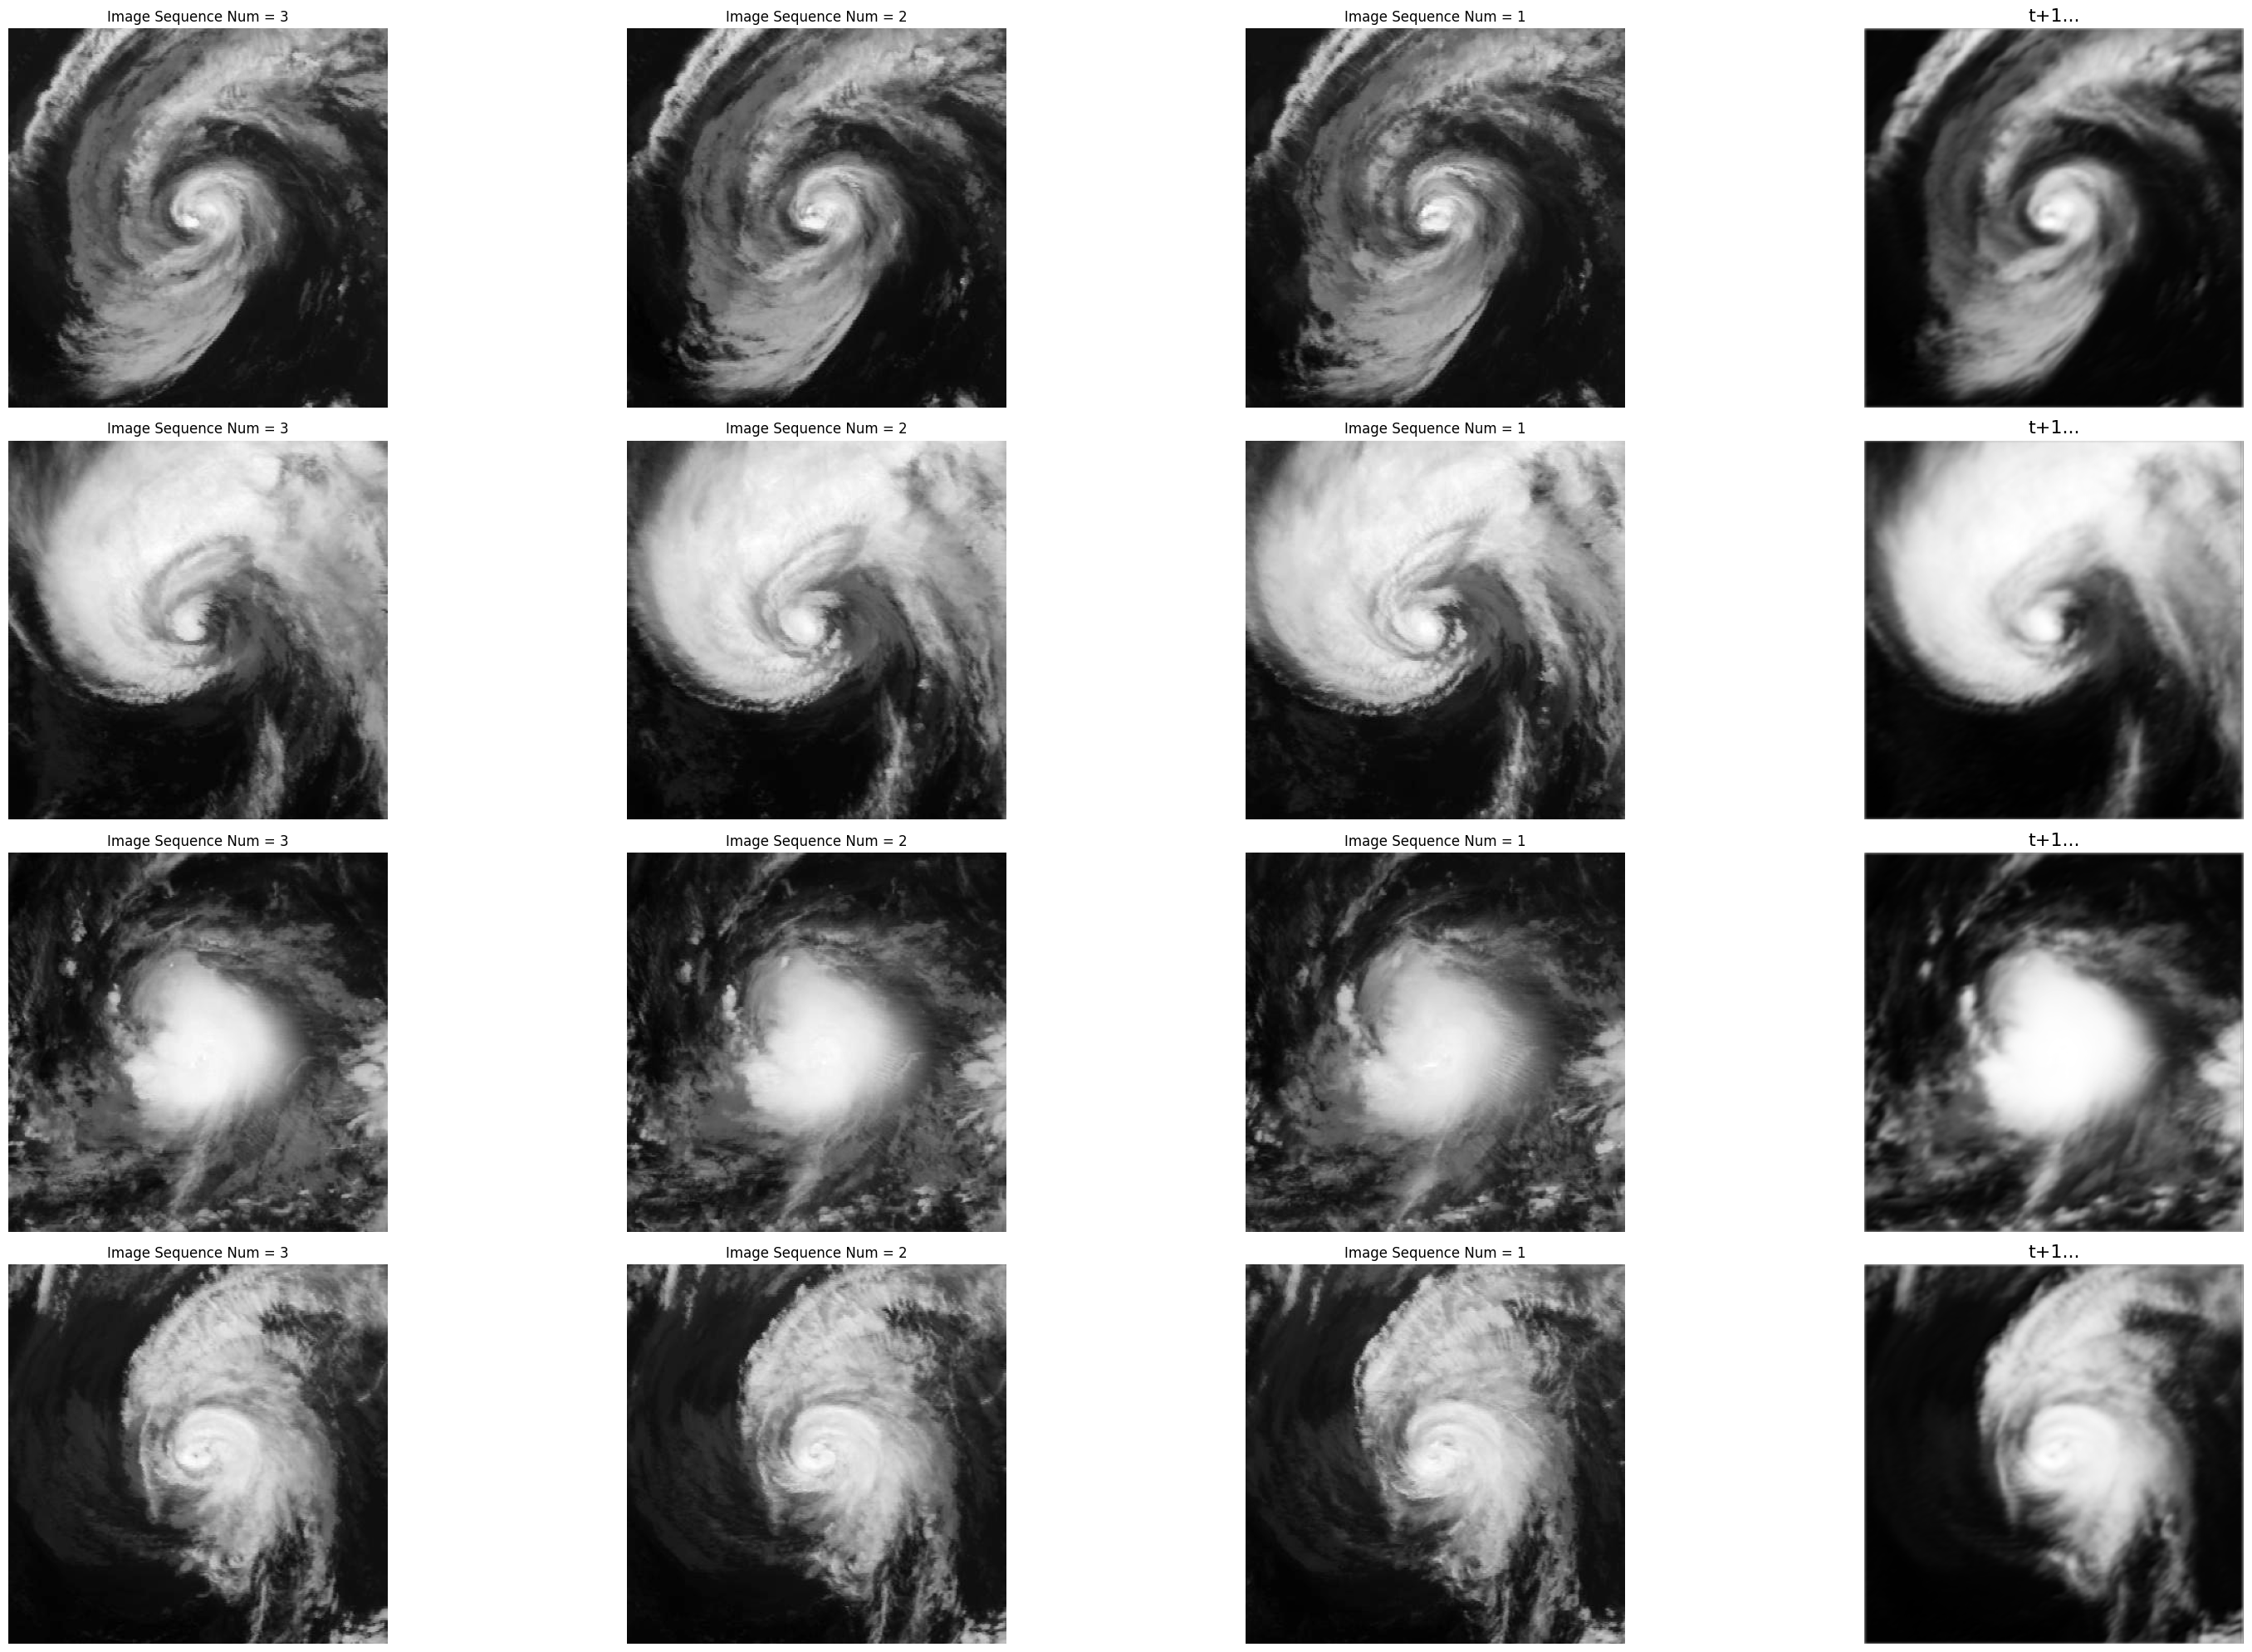

In [697]:
# basic inference
val_batch = next(iter(val_loader))
_img_seq, _target_seq = val_batch
C = 0 # single channel

# generate single next image from a sequence
pred_img = model(_img_seq.to(DEVICE))

fig, axs = plt.subplots(nrows=BATCH_SIZE , ncols=(INPUT_SEQUENCE_LENGTH+1), figsize=(32, 20))
for r in range(axs.shape[0]):
    for c in range(axs.shape[-1]):
        if c <= (INPUT_SEQUENCE_LENGTH-1):
            axs[r, c].imshow(_img_seq[r, c, 0, :, :].detach().cpu(), cmap='gray')
            axs[r, c].set_title(f"Image Sequence Num = {INPUT_SEQUENCE_LENGTH - c}", fontsize=12)
        else:
            axs[r, c].imshow(pred_img[r, -1:, 0, :, :][C].detach().cpu(), cmap='gray')
            axs[r, c].set_title("t+1...", fontsize=16)

        axs[r, c].axis('off')

plt.tight_layout()

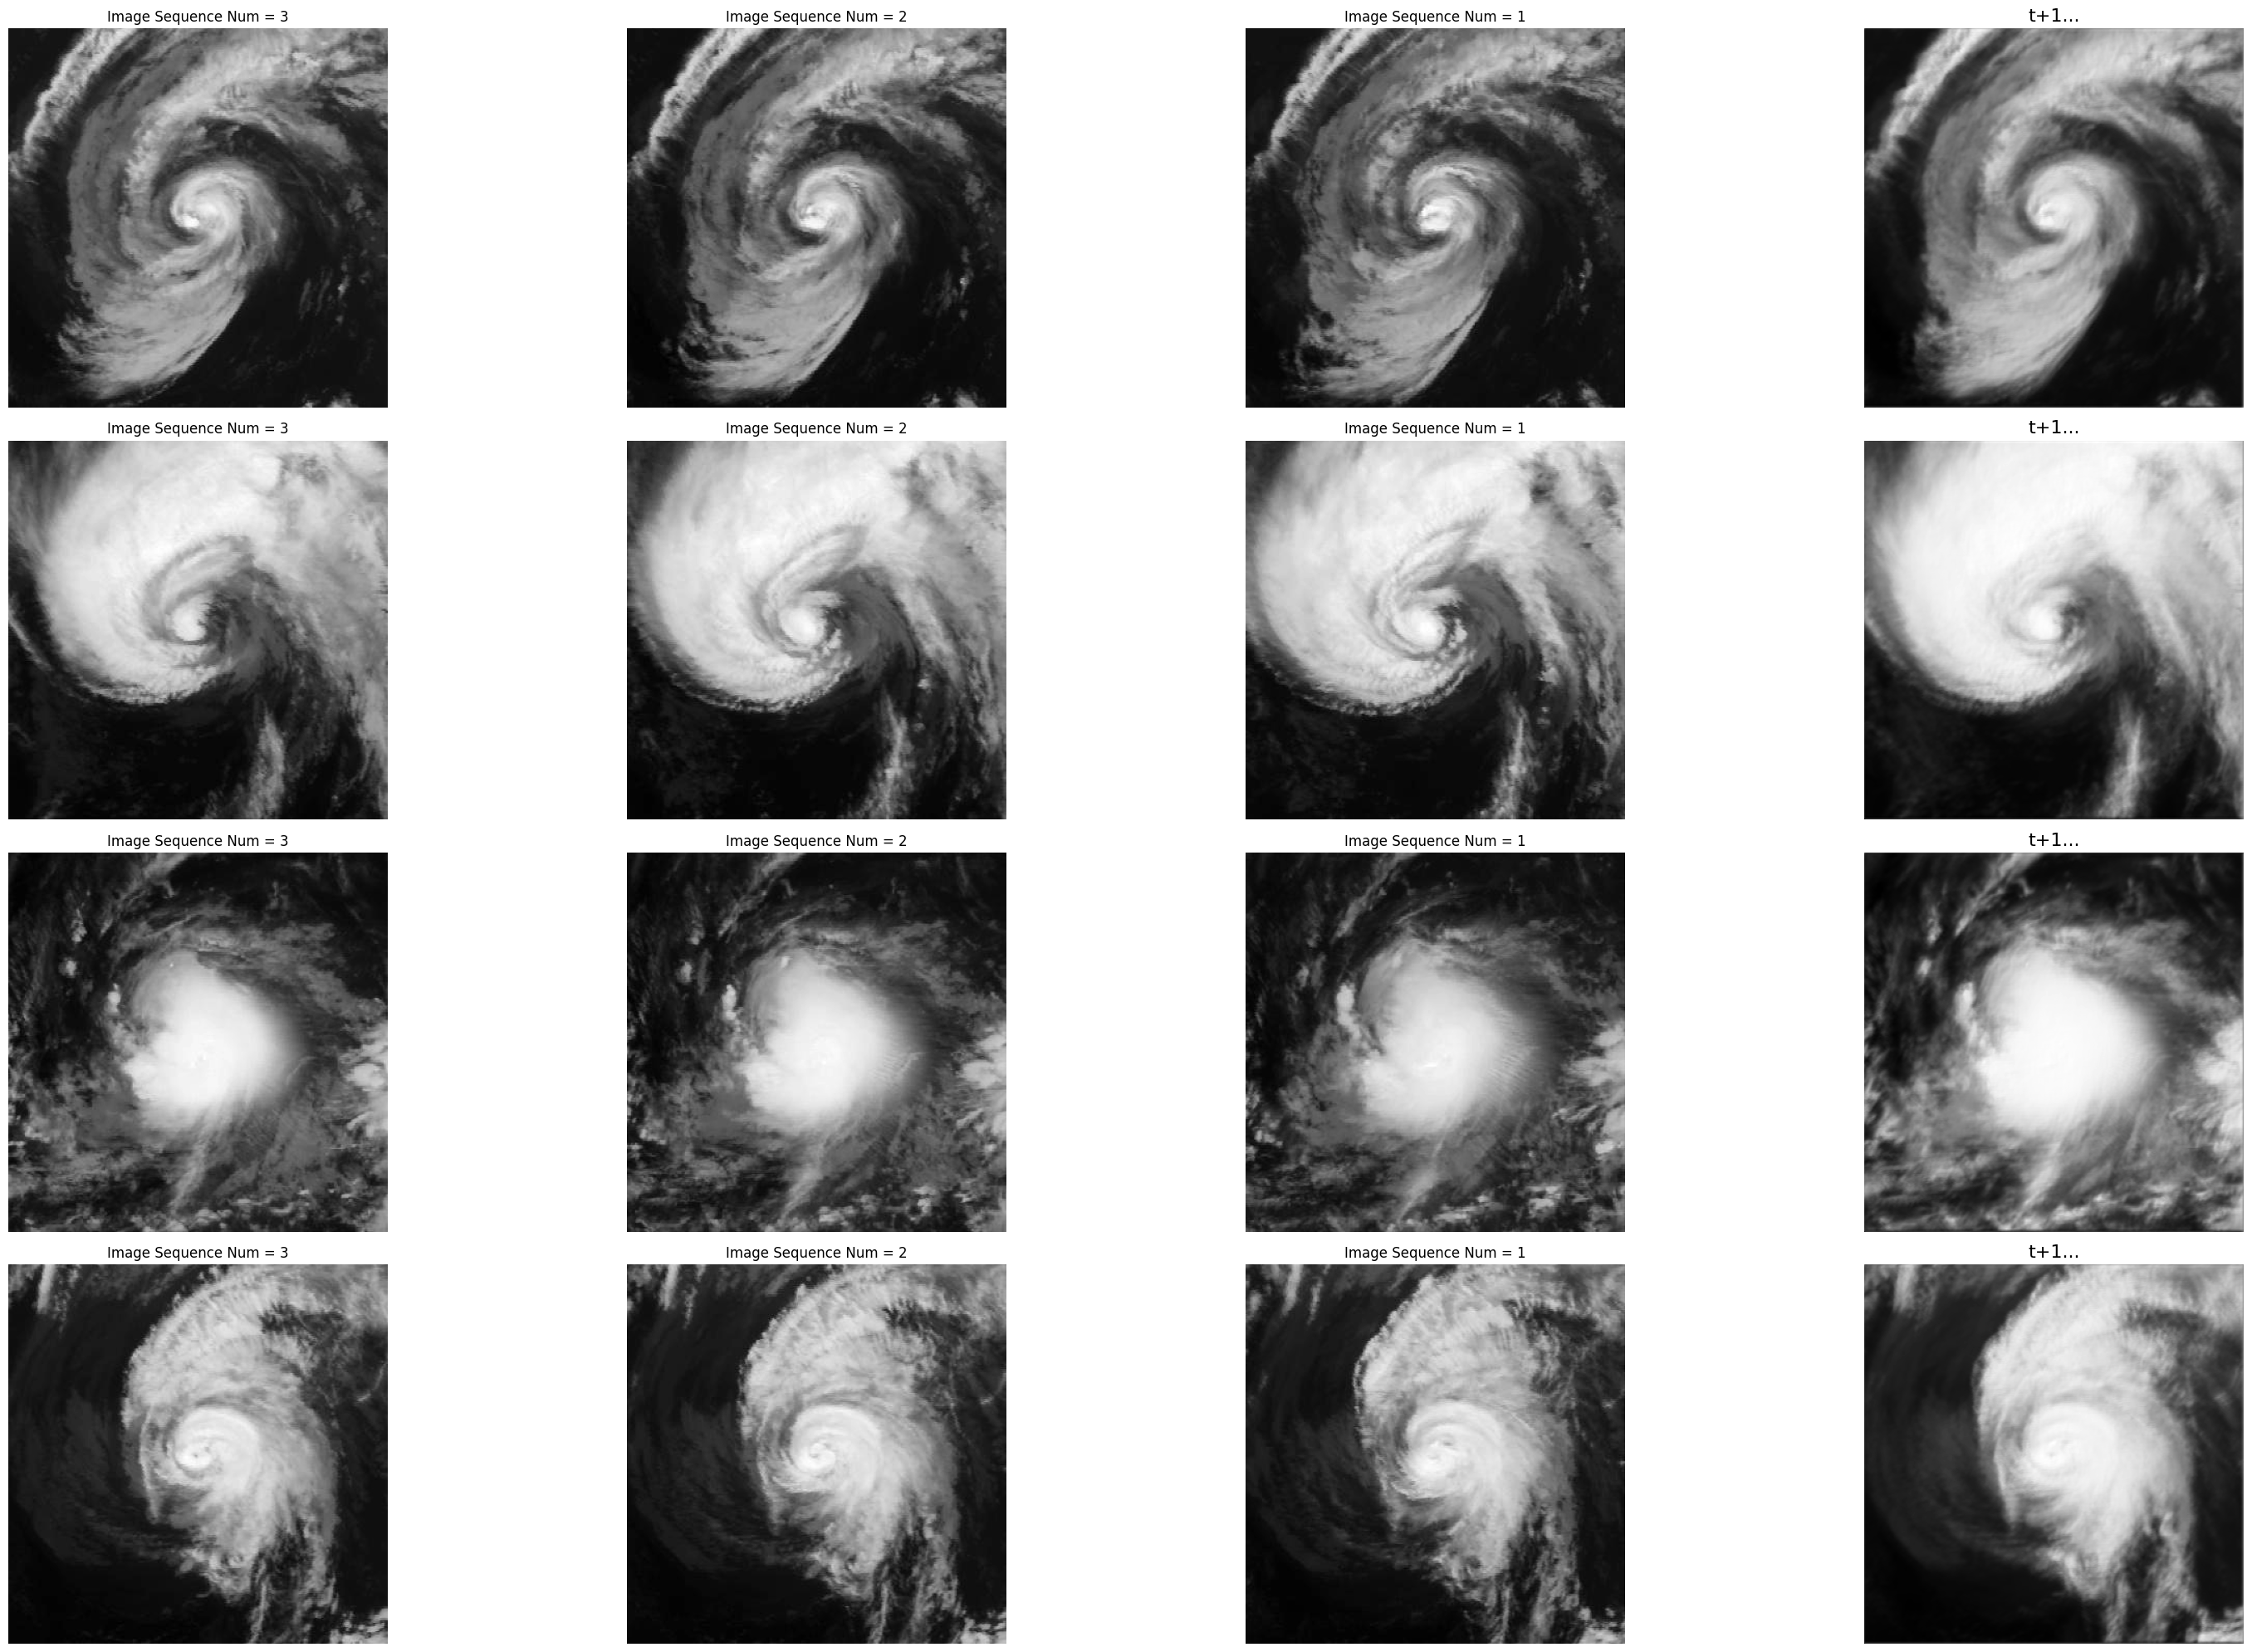

In [694]:
# basic inference
val_batch = next(iter(val_loader))
_img_seq, _target_seq = val_batch
C = 0 # single channel

# generate single next image from a sequence
pred_img = model(_img_seq.to(DEVICE))

fig, axs = plt.subplots(nrows=BATCH_SIZE , ncols=(INPUT_SEQUENCE_LENGTH+1), figsize=(32, 20))
for r in range(axs.shape[0]):
    for c in range(axs.shape[-1]):
        if c <= (INPUT_SEQUENCE_LENGTH-1):
            axs[r, c].imshow(_img_seq[r, c, 0, :, :].detach().cpu(), cmap='gray')
            axs[r, c].set_title(f"Image Sequence Num = {INPUT_SEQUENCE_LENGTH - c}", fontsize=12)
        else:
            axs[r, c].imshow(pred_img[r, -1:, 0, :, :][C].detach().cpu(), cmap='gray')
            axs[r, c].set_title("t+1...", fontsize=16)

        axs[r, c].axis('off')

plt.tight_layout()